# Métodos de Aprendizaje de Máquina

Se importa los paquetes necesarios tanto para cálculo como para graficar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
seaborn.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Cargamos el conjunto de entrenamiento Iris

In [2]:
from sklearn.datasets import load_iris
#Usado para dividir el conjunto de Entrenamiento y de Prueba
from sklearn.model_selection import train_test_split

iris_data = load_iris()

## Método de Naive Bayes

Para la implementación se debe tomar en cuenta algunas cosas:

1. Los datos no necesariamente estan agrupados, es decir, al inicio se encontrarán los pertenecientes a las clase 0, después los pertenecientes a las clase 1, etc.
2. Se desconoce el número de datos por clase.

Por ello la implementación debe ser capaz de realizar el entrenamiento sin que lo anterior sea un inconveniente.

Con respecto al método, se necesita obtener los siguientes valores para la predicción:

1. La frecuencia de cuantos datos tiene cada clase.
2. El promedio de los datos con respecto a la característica por clase.
$$\mu_{i,j} = \frac{1}{n_j} \sum_{i = 1}^{n_j}{x_i}$$

3. La desviación estandar de los datos con respecto a característica por clase.
$$\sigma^2_{i,j} = \frac{1}{n_j} \sum_{i = 1}^{n_j}{(x_i - \mu_{i,j})^2}$$

4. El cálculo de la probabilidad de un descriptor dada una clase se usará una transformada de Gauss.
$$p(x | C_j) = \frac{1}{\sqrt{2\pi\sigma^2_j}} e^{-\frac{(x - \mu_j)^2}{2\sigma^2_j}}$$

In [3]:
class NaiveBayes():
    #El ingreso del número de clases es opcional o de lo contrario se determina en el entrenamiento.
    def __init__(self, n_clases=None):
        if n_clases is None:
            self.n_ys   = None;
        else:
            self.n_ys   = n_clases;
            
        self.n_features = None;
        
        self.frec_clase = None;
        self.mean       = None;
        self.sd         = None;
            
        self.X          = None;
        self.y          = None;

    #Determina la frecuencia por clase, esto porque no necesariamente se tendrá el mismo número de elementos para cada clase
    def frecuencia(self):
        for i in self.y :
            self.frec_clase[i] += 1; 

    #Calcula el promdedio dado por (clase, característica)        
    def means(self):
        accum   = np.zeros((self.n_ys,self.n_features));
        
        i       = 0;
        while i < len(self.y):
            j = 0;
            while j < self.n_features:
                accum[self.y[i]][j]   += self.X[i][j];
                j += 1;
            i += 1;
            
        i = 0;
        while i < self.n_ys:
            j = 0;
            while j < self.n_features:
                self.mean[i][j] = accum[i][j] / self.frec_clase[i];
                j += 1;
            i += 1;

    #Calcula la desviación dado por (Clase, característica), se necesita que antes se calcule el promedio-
    def sds(self):
        accum   = np.zeros((self.n_ys,self.n_features));
        
        i       = 0;
        while i < len(self.y):
            j = 0;
            while j < self.n_features:
                accum[self.y[i]][j]   += np.power(self.X[i][j] - self.mean[self.y[i]][j], 2);
                j += 1;
            i += 1;
            
        i = 0;
        while i < self.n_ys:
            j = 0;
            while j < self.n_features:
                self.sd[i][j] = np.sqrt(accum[i][j] / (self.frec_clase[i]-1));
                j += 1;
            i += 1; 
        
    #Calcula la probabilidad por clase dado un descriptor, determando que pertenece a la clase con mayor probabilidad
    def predict(self,X):
        result  = [];
        prob_y_x = np.ones(self.n_ys);
        
        for x in X:
            for i in range(self.n_ys):
                exp       = np.exp( (np.divide((self.mean[i].transpose() - x) ,self.sd[i])* (self.mean[i]-x))/(-2.0)) ;
                prob_x_y  = exp/ (np.power(2*np.pi, self.n_features/2.0) * np.sqrt(np.linalg.norm(self.sd[i])));
                prob_y    = self.frec_clase[i]/float(len(self.y));
                
                prob_y_x[i] = np.prod(prob_x_y) * prob_y;
            
            result.append(np.argmax(prob_y_x));
            
        return result;
    
    #Entrenamiento: Hace el cálculo de los promedios y desviaciones estandar(De no saber el número de clases las obtine de los valore de y)
    def learn(self, X, y):
        self.X  = X;
        self.y  = y;
        
        #Determina cuantas caracteríticas tiene cada descriptor
        self.n_features = X.shape[1];
        
        if self.n_ys is None:
            self.n_ys = y.max();
            
        self.frec_clase = np.zeros(self.n_ys);
        self.frecuencia();
        
        self.mean       = np.zeros((self.n_ys,self.n_features));
        self.means();
        
        self.sd         = np.zeros((self.n_ys,self.n_features));
        self.sds();
                
    #Determina que porcentaje de aciertos tiene el clasificador con respecto a un conjunto de Test
    def acc(self, X_test, y_test):
        y_values = self.predict(X_test);
        count    = 0;
        for  i,j in zip(y_test,y_values):
            if i == j:
                count += 1.0;
        return count/len(y_test);


### Pruebas del Método de Naive Bayes

Para probar el método sólo es necesario instanciar un objeto, si el número de clases no es ingresada como parámetro en el entrenamiento se determinará. 

In [4]:
#Se necesita ingresar el número de clases o sera calculado durante el entrenamiento
entrenador = NaiveBayes(3);
#Obtenemos un 30% de la data total para el test
X_train, X_test, y_train, y_test = train_test_split(iris_data['data'], iris_data['target'], test_size = 0.30);
entrenador.learn(X_train, y_train);
print("Acc: " + str(entrenador.acc(X_test, y_test)*100) + "%")

Acc: 93.33333333333333%


## K-Nearest Neighbors

Este método determina que dado un descriptor, la clase a la que pertenece es aquella que contine mayor número de puntos cercanos a dicho descriptor, de la siguiente manera:

1. Calcula las distancias a cada uno de los puntos del conjunto de entrenamiento.

2. Ordenar de mayor a menor las distancias, en este caso la distancia Euclidiana.
$$d(X,Y) = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 ... + (x_n - y_n)^2 }$$


3. De los k elementos más determinar, a que clase de elementos es más cercano. 

In [5]:
from scipy.spatial import distance

class KNN():
    #El ingreso del número de clases es opcional o de lo contrario se determina en el entrenamiento y el valo de
    # K es por defecto 3
    def __init__(self, n_clases = None, k = 3):
        if n_clases is None:
            self.n_ys   = None;
        else:
            self.n_ys   = n_clases;
            
        self.k          = k;
            
        self.X          = None;
        self.y          = None;

    
    #Predición: Calcula la clase con mayor número de elementos cercanos al dato x    
    def predict(self,X):
        result    = [];
   
        for x in X:
            distances = [];
            for x_train, y_train in zip(self.X, self.y):
                distances.append((distance.euclidean(x, x_train), y_train));
            distances = sorted(distances, key=lambda d: d[0]);

            
            count_k_y = np.zeros(self.n_ys);
            for i in range(self.k):
                count_k_y[distances[i][1]] += 1;
                
            result.append(np.argmax(count_k_y));
                
        return result;
            
            
    #Entrenamiento: Sólo asigna el conjunto de entrada y salidas de entrenamiento.
    def learn(self, X,y):
        self.X  = X;
        self.y  = y;
        
        if self.n_ys is None:
            self.n_ys = y.max();        
    
    #Precisión: Calcula el procentaje de aciertos con respecto a un conjunto de Test
    def acc(self, X_test, y_test):
        y_values = self.predict(X_test);
        count    = 0;
        for  i,j in zip(y_test,y_values):
            if i == j:
                count += 1.0;
        return count/len(y_test);
    

### Pruebas del Método KNN

Sólo se necesita instanciar un objeto de la clase KNN, para lo cual puede pasarse como parámetros el número de clases o ella también será obtenida durante el proceso de entrenamiento. Por otro lado también si no se ingresa el número "K" de vecinos, este queda por defecto como 3.

In [6]:
#Se necesita ingresar el número de clases o sera calculado durante el entrenamiento y es opcional el valos de K
entrenador = KNN(3);
#Obtenemos un 30% de la data total para el test
X_train, X_test, y_train, y_test = train_test_split(iris_data['data'], iris_data['target'], test_size = 0.30);
entrenador.learn(X_train, y_train);
print("Acc: " + str(entrenador.acc(X_test, y_test)*100) + "%")

Acc: 93.33333333333333%


## Comparaciones 

Dado como ambos métodos no precisan n-iteraciones para el entranamiento, se hará una comparativa con respecto a la precisión dado que tomamos aleatoriamente un porcentaje de la data total asignada al entrenamiento y el restante para pruebas.

Del conjunto de datos se tomará aleatoriamente un porcentaje de ellos para que sea el conjunto de Prueba y el  restante el conjunto de Entrenamiento.

In [10]:
#Porcentajes del conjunto de prueba de la data total
test_sizes = np.array([0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]);
acc_bayes = np.zeros(7);
acc_knn = np.zeros(7);

for i in range(7):
    #Dividimos el conjunto de entrenamiento y de prueba.
    X_train, X_test, y_train, y_test = train_test_split(iris_data['data'], iris_data['target'], test_size = test_sizes[i]);
    
    #La data es procesada para Naive Bayes
    entrenadorNB = NaiveBayes(3);
    entrenadorNB.learn(X_train, y_train);
    acc_bayes[i] = entrenadorNB.acc(X_test, y_test);
    
    #La misma data es procesada para KNN
    entrenadorKNN = KNN(3);
    entrenadorKNN.learn(X_train, y_train);
    acc_knn[i] = entrenadorKNN.acc(X_test, y_test);


Mediante el siguiente gráfico se puede observar de manera comparativa la precisión entre ambos métodos. 

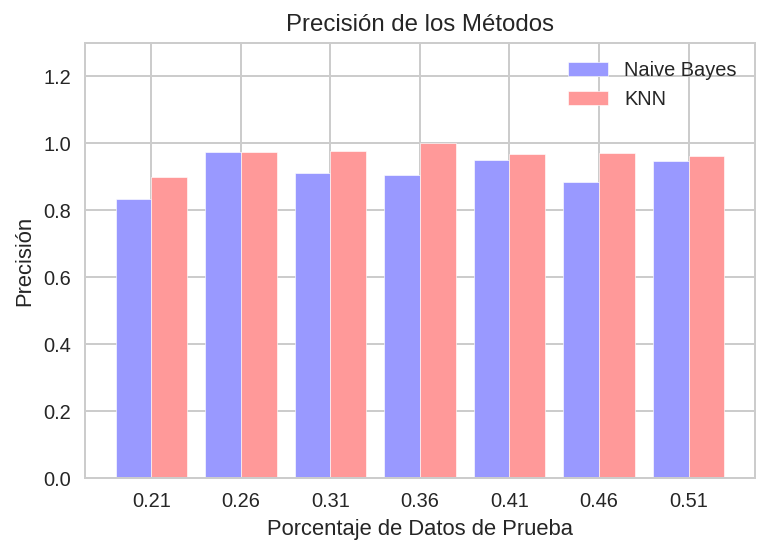

In [8]:
width = 0.02;
fig, ax = plt.subplots()
ax.set_ylabel('Precisión');
ax.set_xlabel('Porcentaje de Datos de Prueba');
ax.set_title('Precisión de los Métodos');
ax.set_xticks(test_sizes + width / 2);
plot1 = plt.bar(test_sizes, acc_bayes , width, facecolor='#9999ff', edgecolor='white', label='Naive Bayes');
plot2 = plt.bar(test_sizes + width, acc_knn, width, facecolor='#ff9999', edgecolor='white', label='KNN');
ax.legend((plot1, plot2), ('Naive Bayes', 'KNN'));
ax.set_ylim(0, 1.3);


También es posible ver como es la distribución de la precisión de las predicciones. De tal manera podemos observar que KNN tiene mejores resultados que Naive Bayes.

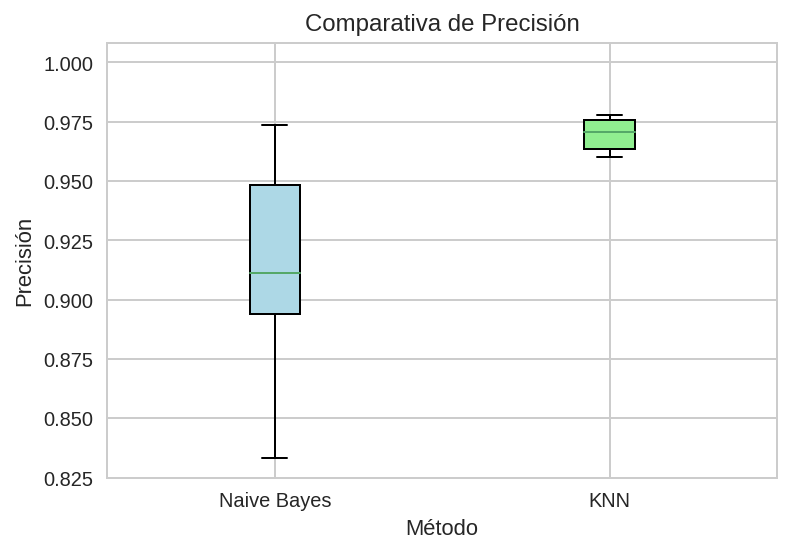

In [9]:
mpl_fig = plt.figure();
ax = mpl_fig.add_subplot(111);
labels = ['Naive Bayes', 'KNN'];
bp = ax.boxplot([acc_bayes, acc_knn], vert=True, patch_artist=True, labels=labels);
ax.set_title('Comparativa de Precisión');
ax.set_ylabel('Precisión');
ax.set_xlabel('Método');


colors = ['lightblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)